# Imports

In [62]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [63]:
from fastai.structured import *
from fastai.column_data import *

PATH = "data/demand-forecasting/"

# Helper Functions

In [64]:
def rmse(y_true, y_pred):
    return math.sqrt(((y_pred-y_true)**2).mean())

In [65]:
def smape(y_pred,y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# Process data

In [66]:
train_raw = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test_raw = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'])

In [67]:
joined = pd.concat([train_raw,test_raw], sort=False)

In [68]:
display(train_raw.head(1))
display(test_raw.head(1))
display(joined.head(1))
display(joined.tail(1))

,date,store,item,sales
0,2013-01-01,1,1,13


,id,date,store,item
0,0,2018-01-01,1,1


,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN


,date,store,item,sales,id
44999,2018-03-31,10,50,NaN,44999.0


In [69]:
add_datepart(joined, 'date', drop=False)

In [70]:
display(train_raw.head(1))
display(test_raw.head(1))
display(joined.head(2))
display(joined.tail(2))

,date,store,item,sales
0,2013-01-01,1,1,13


,id,date,store,item
0,0,2018-01-01,1,1


,date,store,item,sales,id,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400


,date,store,item,sales,id,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
44999,2018-03-31,10,50,NaN,44999.0,2018,3,13,31,5,90,True,False,True,False,False,False,1522454400


## Add extra features

In [71]:
joined["median-store_item-month"] = joined.groupby(['Month',"item","store"])["sales"].transform("median") # median sales for particular item-store combo

joined["mean-store_item-week"] = joined.groupby(['Week',"item","store"])["sales"].transform("mean") # mean sales for particular item-store combo
joined["mean-store_item-dayofweek-month"] = joined.groupby(['Dayofweek','Month',"item","store"])["sales"].transform("mean") # mean sales for particular item-store combo

joined["item-month-sum"] = joined.groupby(['Month',"item"])["sales"].transform("sum") # total sales of that item  for all stores
joined["store-month-sum"] = joined.groupby(['Month',"store"])["sales"].transform("sum") # total sales of that store  for all items

## Extract train and test

In [72]:
train = joined[~joined['sales'].isna()]
test = joined[joined['sales'].isna()]

train.pop('id')
test = test.drop('sales', axis=1)

In [75]:
DataFrameSummary(train).summary()

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,...,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,median-store_item-month,mean-store_item-week,mean-store_item-dayofweek-month,item-month-sum,store-month-sum
count,NaN,913000,913000,913000,913000,913000,913000,913000,913000,913000,...,NaN,NaN,NaN,NaN,913000,913000,913000,913000,913000,913000
mean,NaN,5.5,25.5,52.2503,2015,6.52355,26.6156,15.7278,3.00164,183.1,...,NaN,NaN,NaN,NaN,1.43584e+09,51.7522,52.2503,52.2503,79623.8,398119
std,NaN,2.87228,14.4309,28.8011,1.41402,3.44854,15.061,8.79933,1.99932,105.424,...,NaN,NaN,NaN,NaN,4.55433e+07,26.1032,26.1991,27.2669,36275.8,109357
min,NaN,1,1,0,2013,1,1,1,0,1,...,NaN,NaN,NaN,NaN,1.357e+09,9,8.37143,7.14286,19429,191604
25%,NaN,3,13,30,2014,4,14,8,1,92,...,NaN,NaN,NaN,NaN,1.3964e+09,30,30.7714,30.4091,46668,314559
50%,NaN,5.5,25.5,47,2015,7,27,16,3,183,...,NaN,NaN,NaN,NaN,1.43584e+09,48,48.1429,47.5,76074,385566
75%,NaN,8,38,70,2016,10,40,23,5,274,...,NaN,NaN,NaN,NaN,1.47528e+09,69,69.2571,69.2727,105873,482597
max,NaN,10,50,231,2017,12,53,31,6,366,...,NaN,NaN,NaN,NaN,1.51468e+09,145,146.571,177.455,174769,665974
counts,913000,913000,913000,913000,913000,913000,913000,913000,913000,913000,...,913000,913000,913000,913000,913000,913000,913000,913000,913000,913000
uniques,1826,10,50,213,5,12,53,31,7,366,...,2,2,2,2,1826,233,4347,7791,600,120


In [76]:
DataFrameSummary(test).summary()

,date,store,item,id,Year,Month,Week,Day,Dayofweek,Dayofyear,...,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,median-store_item-month,mean-store_item-week,mean-store_item-dayofweek-month,item-month-sum,store-month-sum
count,NaN,45000,45000,45000,45000,45000,45000,45000,45000,45000,...,NaN,NaN,NaN,NaN,45000,45000,45000,45000,45000,45000
mean,NaN,5.5,25.5,22499.5,2018,2,6.93333,15.5333,2.96667,45.5,...,NaN,NaN,NaN,NaN,1.51861e+09,40.3488,40.8648,40.7061,61496,307480
std,NaN,2.87231,14.431,12990.5,0,0.830003,3.70829,8.71177,1.9858,25.9794,...,NaN,NaN,NaN,NaN,2.24462e+06,19.4677,19.5969,20.4013,26752.3,74690.5
min,NaN,1,1,0,2018,1,1,1,0,1,...,NaN,NaN,NaN,NaN,1.51476e+09,9,8.37143,7.14286,19429,191604
25%,NaN,3,13,11249.8,2018,1,4,8,1,23,...,NaN,NaN,NaN,NaN,1.51667e+09,24,24.3824,24,38686,250494
50%,NaN,5.5,25.5,22499.5,2018,2,7,15.5,3,45.5,...,NaN,NaN,NaN,NaN,1.51861e+09,38,38.4286,37.7273,61725,309114
75%,NaN,8,38,33749.2,2018,3,10,23,5,68,...,NaN,NaN,NaN,NaN,1.52055e+09,54,54.5143,53.8636,82257,352650
max,NaN,10,50,44999,2018,3,13,31,6,90,...,NaN,NaN,NaN,NaN,1.52245e+09,102,107.2,121.304,123894,470838
counts,45000,45000,45000,45000,45000,45000,45000,45000,45000,45000,...,45000,45000,45000,45000,45000,45000,45000,45000,45000,45000
uniques,90,10,50,45000,1,3,13,31,7,90,...,2,2,1,2,90,91,2773,4327,150,30


In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 22 columns):
date                               913000 non-null datetime64[ns]
store                              913000 non-null int64
item                               913000 non-null int64
sales                              913000 non-null float64
Year                               913000 non-null int64
Month                              913000 non-null int64
Week                               913000 non-null int64
Day                                913000 non-null int64
Dayofweek                          913000 non-null int64
Dayofyear                          913000 non-null int64
Is_month_end                       913000 non-null bool
Is_month_start                     913000 non-null bool
Is_quarter_end                     913000 non-null bool
Is_quarter_start                   913000 non-null bool
Is_year_end                        913000 non-null bool
Is_year_start               

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 22 columns):
date                               45000 non-null datetime64[ns]
store                              45000 non-null int64
item                               45000 non-null int64
id                                 45000 non-null float64
Year                               45000 non-null int64
Month                              45000 non-null int64
Week                               45000 non-null int64
Day                                45000 non-null int64
Dayofweek                          45000 non-null int64
Dayofyear                          45000 non-null int64
Is_month_end                       45000 non-null bool
Is_month_start                     45000 non-null bool
Is_quarter_end                     45000 non-null bool
Is_quarter_start                   45000 non-null bool
Is_year_end                        45000 non-null bool
Is_year_start                      45000 non-

In [79]:
test.id = test.id.astype('int32')
test.id.dtype

dtype('int32')

## Remove outliers

In [80]:
len(train[train.sales==0]),len(train[train.sales<7]),len(train[train.sales>186])

(1, 1535, 85)

In [81]:
train.sales.quantile(q=0.001),train.sales.quantile(q=0.01),train.sales.quantile(q=0.99),train.sales.quantile(q=0.999)

(6.0, 10.0, 135.0, 164.0)

In [82]:
# tr = train[(train.sales>train.sales.quantile(q=0.001)) & (train.sales<train.sales.quantile(q=0.99))]

In [83]:
# tr.sales.min(),tr.sales.max(),tr.sales.median(), len(tr), len(train), (len(train)-len(tr))

In [84]:
# exclude row with zero sales
#train = train[train.sales!=0]
train = train[(train.sales>train.sales.quantile(q=0.01)) & (train.sales<train.sales.quantile(q=0.99))]

## Reset index and save

In [85]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [86]:
os.makedirs('tmp', exist_ok=True)

# train.to_feather(f'{PATH}train_raw_with_zero_sales')
# test.to_feather(f'{PATH}test_raw_with_zero_sales')

train.to_feather(f'{PATH}tmp/train_raw_no_zero_sales_v2')
test.to_feather(f'{PATH}tmp/test_raw_no_zero_sales_v2')

# Data Cleaning and Feature Engineering

In [87]:
use_all_data = 1
merge_val_to_train = 0

In [88]:
cat_vars = ['store', 'item', 'Month', 'Week', 'Day','Dayofweek', 'Dayofyear']
contin_vars = ['Year', 'Elapsed',
               'median-store_item-month','mean-store_item-week','mean-store_item-dayofweek-month',
               'item-month-sum','store-month-sum'] 

# Elapsed = Unix Timestamp ( 0 = 1 Jan 1970 12.00am and can be negative)
# 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start','Is_year_end', 'Is_year_start'

In [89]:
# train2 = pd.read_feather(f'{PATH}train_raw_with_zero_sales')
# test2 = pd.read_feather(f'{PATH}test_raw_with_zero_sales')

train2 = pd.read_feather(f'{PATH}tmp/train_raw_no_zero_sales_v2')
test2 = pd.read_feather(f'{PATH}tmp/test_raw_no_zero_sales_v2')

In [91]:
# Reorg train and test dataset

dependent = 'sales'
train2 = train2[cat_vars+contin_vars+[dependent, 'date']].copy()

test2[dependent] = 0 # broadcast zero for 'Sales' dummy col
test2 = test2[cat_vars+contin_vars+[dependent, 'date', 'id']].copy()

In [92]:
n = len(train2)
n # total training data

(892473, 45000)

In [93]:
for v in cat_vars: train2[v] = train2[v].astype('category').cat.as_ordered()
apply_cats(test2, train2)

for v in contin_vars:
    train2[v] = train2[v].fillna(0).astype('float32')
    test2[v] = test2[v].fillna(0).astype('float32')

In [96]:
display(train2.head(1))
display(test2.head(1))

,store,item,Month,Week,Day,Dayofweek,Dayofyear,Year,Elapsed,median-store_item-month,mean-store_item-week,mean-store_item-dayofweek-month,item-month-sum,store-month-sum,sales,date
0,1,1,1,1,1,1,1,2013.0,1.356998e+09,13.0,13.970589,11.545455,22987.0,249352.0,13.0,2013-01-01


,store,item,Month,Week,Day,Dayofweek,Dayofyear,Year,Elapsed,median-store_item-month,mean-store_item-week,mean-store_item-dayofweek-month,item-month-sum,store-month-sum,sales,date,id
0,1,1,1,1,1,0,1,2018.0,1.514765e+09,13.0,13.970589,11.190476,22987.0,249352.0,0,2018-01-01,0


In [97]:
if use_all_data == 0:
    # Get a sample m from all training data
    m = 200000
    idxs = get_cv_idxs(n, val_pct=m/n) # get random sample by index, nothing to do with validation
    train3 = train2.iloc[idxs].set_index("date")
    sample_size = len(train3)
    sample_size
elif use_all_data == 1:
    # Set sample size equal to total data to use all data
    sample_size = n
    train3 = train2.set_index("date")
else:
    pass
    #raise Exception()

In [98]:
len(train3), len(train2), len(test2)

(892473, 892473, 45000)

In [99]:
df_train, y_train, nas, mapper = proc_df(train3, 'sales', do_scale=True)

In [100]:
test3 = test2.set_index("date")

In [101]:
df_test, _, nas, mapper = proc_df(test3, 'sales', do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In [102]:
if merge_val_to_train == 0:
    val_idx = np.flatnonzero(
        (df_train.index<=datetime.datetime(2017,3,31)) & (df_train.index>=datetime.datetime(2017,1,1)))
elif merge_val_to_train == 1:
    val_idx = [0]
else:
    pass

In [103]:
len(df_train), len(val_idx), len(df_test)

(44284, 45000, 45000)

# Deep Learning

## Get Data

In [104]:
def get_data():
    return ColumnarModelData.from_data_frame(PATH, val_idx, 
                                             df_train, y_train.astype(np.float32), 
                                             cat_flds=cat_vars, bs=128,
                                             test_df=df_test)

In [105]:
md = get_data()

## Get Embedding Size

In [106]:
cat_sz = [(c, len(train3[c].cat.categories)+1) for c in cat_vars]
cat_sz

In [108]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

## Create Architecture

In [110]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=None)

## Get Learning Rate

In [111]:
m.lr_find()

 65%|███████████████████████████████████████████▎                       | 4278/6627 [00:40<00:22, 106.12it/s, loss=154]

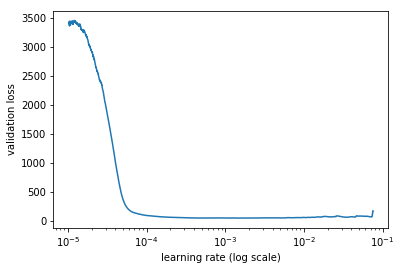

In [112]:
m.sched.plot()

In [113]:
lr = 1e-4

## Fit on Sample Data

In [114]:
m.fit(lr, 3, metrics=[smape, rmse])

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      49.917467  44.608686  12.782563  6.544238  
    1      49.786099  46.910046  13.245454  6.715399                                                                   
    2      48.994551  43.417881  12.411528  6.441641                                                                   


[array([43.41788]), 12.411528281538416, 6.441640865732325]

In [115]:
m.fit(lr, 5, metrics=[smape, rmse], cycle_len=1)

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      48.800212  43.46953   12.502517  6.448118  
    1      47.458861  43.396728  12.459473  6.439961                                                                   
    2      47.171085  43.442705  12.458578  6.442836                                                                   
    3      48.18632   43.520123  12.488721  6.449593                                                                   
    4      48.385984  43.610055  12.514295  6.456316                                                                   


[array([43.61006]), 12.514295039531413, 6.456316279676727]

In [116]:
m.fit(lr, 2, metrics=[smape, rmse], cycle_len=3)

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      49.364644  43.646198  12.47901   6.457057  
    1      47.703377  43.354953  12.443804  6.436327                                                                   
    2      47.600979  43.647861  12.489683  6.456676                                                                   
    3      47.496768  43.952143  12.502331  6.476033                                                                   
    4      47.582885  44.718871  12.681972  6.538532                                                                   
    5      47.94648   43.709168  12.488996  6.460296                                                                   


[array([43.70917]), 12.488995760095097, 6.46029580943394]

In [117]:
#m.fit(lr, 3, metrics=[smape, rmse], cycle_len=1, cycle_mult=2)

In [118]:
m.save('md_sample_trained_v5_no_val')

In [119]:
m.load('md_sample_trained_v5_no_val')

## Fit on All Data (with/without validation)

In [120]:
md_all_3mth_val = get_data()

In [121]:
m.set_data(md_all_3mth_val)

In [122]:
m.fit(lr, 3, metrics=[smape, rmse], cycle_mult=2)

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      48.904332  46.164712  13.017869  6.647607  
    1      47.510098  44.031017  12.552728  6.483502                                                                   
    2      48.262468  44.263355  12.668696  6.50952                                                                    
    3      48.448163  43.776882  12.476606  6.464917                                                                   
    4      47.902131  47.465191  13.081117  6.732649                                                                   
    5      47.06303   43.847519  12.459706  6.467104                                                                   
    6      48.506478  43.519469  12.416801  6.44673                                                                    


[array([43.51947]), 12.416800836809992, 6.4467301933038055]

In [123]:
m.fit(lr, 3, metrics=[smape, rmse])

epoch      trn_loss   val_loss   smape      rmse                                                                       
    0      47.307053  43.413857  12.407009  6.445204  
    1      49.111779  44.001999  12.477632  6.47863                                                                    
    2      47.897128  43.462459  12.397334  6.44285                                                                    


[array([43.46246]), 12.397333660699436, 6.442850385327619]

In [ ]:
m.save('md_all_3mth_val_trained_v5_no_val')

In [ ]:
m.load('md_all_3mth_val_trained_v5_no_val')

# Predict on test data

In [ ]:
pred_test = m.predict(True)

In [ ]:
test_raw['sales'] = pred_test

In [ ]:
csv_fn=f'{PATH}tmp/ANN_v5a.csv'

In [ ]:
test[['id','sales']].to_csv(csv_fn, index=False)

# Variations of Data Engineering

## Version 1 (Using 'Year' as continuous variable, removed 'Elapsed')

## Version 2 (Using 'Elapsed' as continuous variable, 'Year' as categorical)

## Version 3 (Using 'Year' and 'Elapsed' as continuous variable)

## Version 4 - Based on Version 3 but with more features

# Visualizations

## Prediction on validation data

In [ ]:
m.load('md_sample_trained_v4_no_val')

In [ ]:
test_val = pd.DataFrame(train2.iloc[val_idx][['date','store']])

In [ ]:
len(test_val)

In [ ]:
pred_val = m.predict(False)  # predict on validation data

In [ ]:
len(test_val), len(pred_val)

In [ ]:
# stick the prediction to copy of test data, and then offset by 12 months 
# because that's how our validation data is defined (2017-01-01 to 2017-03-31)
test_val['sales'] = pred_val
# test_val['date'] = test_val['date'] - pd.DateOffset(months=12)

In [ ]:
# test_val.drop('id',axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(30,120)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(1): #set range to 10 to show all 10 stores
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[(train.store==(store+1)) & (train.date.dt.year>2015)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_val[test_val.store==(store+1)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()

In [ ]:
plt.figure(figsize=(30,150)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(1): #set range to 10 to show all 10 stores
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[(train.store==(store+1)) 
                                                & (((train.date.dt.year==2017) & (train.date.dt.month<5))
                                                | ((train.date.dt.year==2016) & (train.date.dt.month>11)))],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_val[test_val.store==(store+1)],
                                          index=['date'],
                                          columns=['store',],
                                          values='sales',
                                          aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.grid()
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()

## Prediction on test data

In [ ]:
m.load('md_all_3mth_val_trained_v3_no_val')

In [ ]:
pred_test = m.predict(True) # predict on test data# 

In [ ]:
test_pred = test.copy()

In [ ]:
test_pred['sales'] = pred_test

In [ ]:
test_pred.drop('id',axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(30,120)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(10):
    plt.subplot(10,1,store+1) 
    performance_of_store = pd.pivot_table(train[train.store==(store+1)],index=['date'],
                                          columns=['store',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_store,color='b',label="Store-"+str(store+1)+" Actual Total sales")
    
    performance_of_store = pd.pivot_table(test_pred[test_pred.store==(store+1)],index=['date'],
                                          columns=['store',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_store,color='r',label="Store-"+str(store+1)+" Predicted total sales")
    plt.legend(loc='upper left', shadow=True, prop={'size': 24})
plt.show()